# **Project 2 - Multi-Class Logistic Regression and Gradient Descent**

First we imported neccessary library


In [ ]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
import timeit
from sklearn.model_selection import train_test_split # Never use in our code! Except for KNN since we can use off-the-shelf implementation
from sklearn.model_selection import KFold # Never use in our code! Except for KNN since we can use off-the-shelf implementation
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state

# --------------------------------------------------------

We have two datasets. The first one is about digits. 

We have 64 ***X_digits*** features, forming a 8*8 pixel picture.

The label ***Y_digits*** is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].

The method load.digits() give us 1797 samples, the ***Y_digits*** are distributed randomly.

For instance, the 118th sample represents digit **7**.




First data's shape: (1797, 64)


<Figure size 432x288 with 0 Axes>

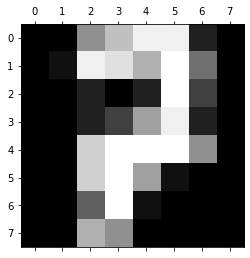

The #118 image shoule be 7.0


In [ ]:
digits = load_digits()
X_digits = digits.data.astype(np.float32)
Y_digits = digits.target.reshape(-1,1).astype(np.float32)

number = 118
print("First data's shape: " + str(digits.data.shape))
plt.gray() 
plt.matshow(digits.images[number]) 
plt.show() 
print("The #" + str(number) + " image shoule be " + str(Y_digits[number][0]))
#print("The 8 * 8 features is " + str(X_digits[number]))


# --------------------------------------------------------

The second is about miceprotein from openML. 

It has 77 ***X_mice*** features, forming a combination of protein in mice brain.

The label ***Y_mice*** is ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s'].

The method fetch_openml() give us 1080 samples, the ***Y_mice*** are **not** distributed randomly. So we disorganize it by using random state.

Expression levels of 77 proteins measured in the cerebral cortex of 8 classes of control and Down syndrome mice exposed to context fear conditioning, a task used to assess associative learning. 

More details at [https://www.openml.org/d/40966](https://www.openml.org/d/40966)




In [ ]:

# one dataset from openml
mice = fetch_openml(name='miceprotein', version=4)
mice.data = np.nan_to_num(mice.data)
print("Second data's shape: " + str(mice.data.shape))

X_mice = mice.data.astype(np.float32)
Y_mice = mice.target.reshape(-1,1)

random_state = check_random_state(23) # This number dosn't matter.
permutation = random_state.permutation(X_mice.shape[0]) # X_mice.shape[0] = 1080, which means we have a 1080 unsorted array.

X_mice = X_mice[permutation]
Y_mice = Y_mice[permutation]
print("Y_mice shape " + str(Y_mice.shape))

Second data's shape: (1080, 77)
Y_mice shape (1080, 1)


# --------------------------------------------------------

GradientDescent: the default max_iters=1e3, epsilon=1e-8, which will be probably never changed in this project

The momentum is implemented according to the formula on slides. 




In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e3, epsilon=1e-20, batch_size = 64, record_history=False, beta = 0.9, T = 1e4):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.T = T
        self.batch_size = batch_size
        if record_history:
            self.loss_history = []                 #to store the weight history for visualization
            self.w_history = []
            self.accuracy_history = []
        self.beta = beta

    def create_minibatches(self, x, y):
        choice = np.arange(x.shape[0])
        np.random.shuffle(choice)
        count = self.batch_size
        x_batches = [np.array(x[choice[:count]])]                    
        y_batches = [np.array(y[choice[:count]])]
        while count < len(choice):
          x_batches.append(np.array(x[choice[count: count + self.batch_size]]))
          y_batches.append(np.array(y[choice[count: count + self.batch_size]]))
          count += self.batch_size
        
        count -= self.batch_size
        x_batches.append(np.array(x[choice[count:len(choice)-1]]))
        y_batches.append(np.array(y[choice[count:len(choice)-1]]))

        x_batches = np.array(x_batches)
        y_batches = np.array(y_batches)

        return x_batches, y_batches

    def run(self, x, y, w):
        grad = np.inf
        interations = 0
        t = 0
        del_w = w
        while np.linalg.norm(grad) > self.epsilon and interations < self.max_iters:
            interations += 1;
            x_batches, y_batches = self.create_minibatches(x,y)
            for (x_batch, y_batch) in zip(x_batches, y_batches):
              error = y_batch - self.predict(x_batch, w)
              grad = - np.dot(error.T, x_batch)
              del_w = self.beta * del_w + (1-self.beta) * grad
              w = w - self.learning_rate * del_w       # weight update step
            
            if self.record_history:
              loss = self.cross_entropy(y, self.predict(x, w))
              self.loss_history.append(loss)
              # print("lose is " + str(loss))
            if len(self.loss_history) > 1:
              if self.loss_history[len(self.loss_history)-1] >= self.loss_history[len(self.loss_history)-2]: # Not decreasing
                t += 1
              else :
                t = 0
            if t >= self.T :
              break
            #print("grad is " + str(np.linalg.norm(grad)))
        return w

    def predict(self, x, w):
        pre_vals = np.dot(x, w.T)
        return self.softmax(pre_vals)
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)

    def cross_entropy(self, y, probs):
        return -1 * np.mean(y * np.log(probs))

# --------------------------------------------------------

MultiClassLogisticRegression: the default bias (w0) = true which will be probably never changed in this project




In [ ]:
class MultiClassLogisticRegression:

    def __init__(self, if_bias=True):
        self.if_bias = if_bias
    
    def fit(self, x, y, optimizer):  
        classes = np.unique(y) 
        class_labels = {c:i for i,c in enumerate(classes)} 
        C = len(classes)

        if self.if_bias:
          x = np.insert(x, 0, 1, axis=1)
        y = np.eye(C)[np.vectorize(lambda c: class_labels[c])(y).reshape(-1)]
        
        N,D = x.shape 

        self.loss = []
        self.weights = np.zeros(shape=(C, D)) 

        self.weights = optimizer.run(x, y, self.weights)
        return self

# --------------------------------------------------------

Accuracy: given a y_head and y.

First we convert the y to 1-D array.

Second we predict y_head as a label. 

For example, if y_head[0] = [0.85, 0.1, 0.05] -> [1, 0, 0] -> 1 -> first label




In [ ]:
# A score method

def accuracy(y_head, y):
  y = y.reshape(-1)
  classes = np.unique(y) 
  predict = np.vectorize(lambda c: classes[c])(np.argmax(y_head, axis=1))
  return np.mean(predict == y)

In [ ]:
def accuracy_CE(y_head, y):
    classes = np.unique(Y_digits) 
    class_labels = {c:i for i,c in enumerate(classes)} 
    C = len(classes)
    y = np.eye(C)[np.vectorize(lambda c: class_labels[c])(y).reshape(-1)]
    
    return 1 + 1 * np.mean(y * np.log(y_head))

In [2]:
# Split a dataset into a train and test index
def myKFold(split, size):
    choice = np.arange(size)
    np.random.shuffle(choice)
    count = size // split
    constant_count = size // split
    train_index = []
    test_index = []
    i=0
    j=0
    while(i<split):
        train = []
        test = []
        while(j<constant_count*(split-1)):
            train.append((constant_count * i + j)%size)
            j += 1
        while(j<size):
            test.append((constant_count * i + j)%size)
            j += 1
        j = 0
        i += 1
        train_index.append(train)
        test_index.append(test)
    #train_index = np.array(train_index)
    #test_index = np.array(test_index)
    result = []
    k=0
    while(k<5):
        result.append([train_index[k], test_index[k]])
        k += 1
    result = np.array(result)
    return result

In [ ]:
#CV Digits - Grid Searching
#To find a better combination of Learning rate, Batch_size, termination T, Momentum

from sklearn.model_selection import KFold
import time
def cvD(X_digits,Y_digits,lrate, num_batch, m, t = 1e4):    
  runtime = 0
  vc = 0
  i = 0
  for train_index, test_index in myKFold(split = 5, size = len(X_digits)): # Run 5 times 
    X_train, X_test, Y_train, Y_test = X_digits[train_index], X_digits[test_index], Y_digits[train_index], Y_digits[test_index]
    optimizer = GradientDescent(learning_rate=lrate, batch_size=num_batch, record_history=True, beta = m, T = t)
    model = MultiClassLogisticRegression()
    starttime = time.time()
    model.fit(X_train, Y_train, optimizer)
    X_test = np.insert(X_test, 0, 1, axis=1)
    Y_result = optimizer.predict(X_test, model.weights)
    score = accuracy(Y_result, Y_test)
    endtime = time.time()
    timecost = endtime - starttime
    i += 1
    #print(f'Training time for current fold {i}: {timecost}')
    runtime += timecost
    vc += score

  valid_accuracy_avg = vc / 5
  runtime_avg = runtime / 5
  #print(f'Average validation accuracy: {valid_accuracy_avg}\n')
  return valid_accuracy_avg, runtime_avg

alphas = [0.005 + 0.005 * i for i in range (3)]
number_of_batches = [10 + 20*i for i in range(3)]
Ms = [0.9 + 0.02 * i for i in range(3)]

best_time = 99999999
best_accuracy = 0
best_accuracy_hyperparams = []
best_time_hyperparams = []
#best_hyperparams_score = []

for lrate in alphas:
  for num_batch in number_of_batches:
    for m in Ms:
        # print(f'------------------Training on params: learning_rate={lrate},  number_of_batches={num_batch}, Momentum={m}------------- \n')
        # get accuracy for each set of training parameters
        vaa, rta = cvD(X_digits, Y_digits, lrate,num_batch, m)
        if (vaa > best_accuracy):
            best_accuracy = vaa
            best_accuracy_hyperparams = [lrate, num_batch, m]
        if (rta < best_time):
            best_time = rta
            best_time_hyperparams = [lrate, num_batch, m]

print(f'digits hyparameters with the best accuracy: [Learning rate, Batch_size, Momentum]: {best_accuracy_hyperparams}, best_accuracy: {best_accuracy}')
print(f'digits hyparameters with the best accuracy: [Learning rate, Batch_size, Momentum]: {best_time_hyperparams}, best_time: {best_time}')



/Users/yuelinliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
<ipython-input-4-fe159aa4a71d>:71: RuntimeWarning: divide by zero encountered in log
  return -1 * np.mean(y * np.log(probs))
<ipython-input-4-fe159aa4a71d>:71: RuntimeWarning: invalid value encountered in multiply
  return -1 * np.mean(y * np.log(probs))
<ipython-input-4-fe159aa4a71d>:68: RuntimeWarning: overflow encountered in exp
  return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)
<ipython-input-4-fe159aa4a71d>:68: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)


digits hyparameters with the best accuracy: [Learning rate, Batch_size, termination T, Momentum]: [0.01, 30, 0.92], best_accuracy: 0.9666125038687712
digits hyparameters with the best accuracy: [Learning rate, Batch_size, termination T, Momentum]: [0.015, 10, 0.92], best_time: 0.028541135787963866


In [ ]:
#CV Mice - Grid Searching
#To find a better combination of Learning rate, Batch_size, termination T, Momentum

from sklearn.model_selection import KFold
import time
def cvM(X_mice,Y_mice,lrate, num_batch, m, t = 1e4):    
  runtime = 0
  vc = 0
  i = 0
  for train_index, test_index in myKFold(split = 5, size = len(X_mice)): # Run 5 times
    X_train, X_test, Y_train, Y_test = X_mice[train_index], X_mice[test_index], Y_mice[train_index], Y_mice[test_index]
    optimizer = GradientDescent(learning_rate=lrate, batch_size=num_batch, record_history=True, beta = m, T=t)
    model = MultiClassLogisticRegression()
    starttime = time.time()
    model.fit(X_train, Y_train, optimizer)
    X_test = np.insert(X_test, 0, 1, axis=1)
    Y_result = optimizer.predict(X_test, model.weights)
    score = accuracy(Y_result, Y_test)
    endtime = time.time()
    timecost = endtime - starttime
    i += 1
    #print(f'Training time for current fold {i}: {timecost}')
    runtime += timecost
    vc += score

  valid_accuracy_avg = vc / 5
  runtime_avg = runtime / 5
  #print(f'Average validation accuracy: {valid_accuracy_avg}\n')
  return valid_accuracy_avg, runtime_avg

alphas = [0.01 + 0.01 * i for i in range (3)]
number_of_batches = [10 + 5*i for i in range(3)]
Ms = [0.9 + 0.02 * i for i in range(3)]

best_time = 99999999
best_accuracy = 0
best_accuracy_hyperparams = []
best_time_hyperparams = []
#best_hyperparams_score = []

for lrate in alphas:
  for num_batch in number_of_batches:
    for m in Ms:
        # print(f'------------------Training on params: learning_rate={lrate},  number_of_batches={num_batch}, Momentum={m}------------- \n')
        # get accuracy for each set of training parameters
        vaa, rta = cvM(X_mice, Y_mice, lrate,num_batch, m)
        if (vaa > best_accuracy):
            best_accuracy = vaa
            best_accuracy_hyperparams = [lrate, num_batch, m]
        if (rta < best_time):
            best_time = rta
            best_time_hyperparams = [lrate, num_batch, m]

print(f'mice hyparameters with the best accuracy: [Learning rate, Batch_size, Momentum]: {best_accuracy_hyperparams}, best_accuracy: {best_accuracy}')
print(f'mice hyparameters with the best accuracy: [Learning rate, Batch_size, Momentum]: {best_time_hyperparams}, best_time: {best_time}')



mice hyparameters with the best accuracy: [Learning rate, Batch_size, Momentum]: [0.03, 15, 0.92], best_accuracy: 0.9898148148148149
mice hyparameters with the best accuracy: [Learning rate, Batch_size, Momentum]: [0.01, 20, 0.9400000000000001], best_time: 2.259470558166504


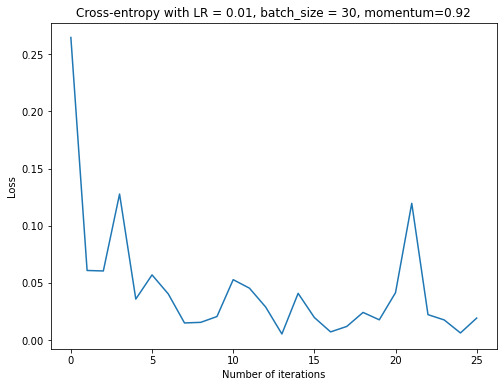

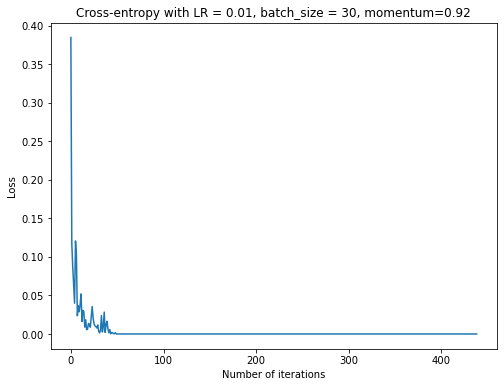

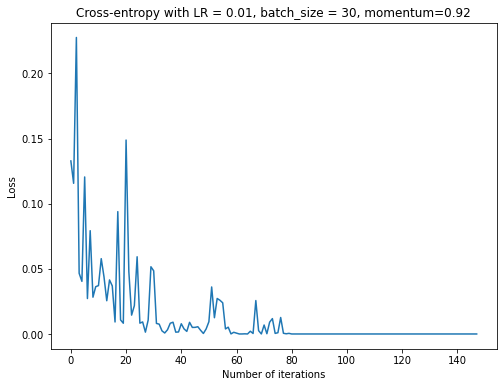

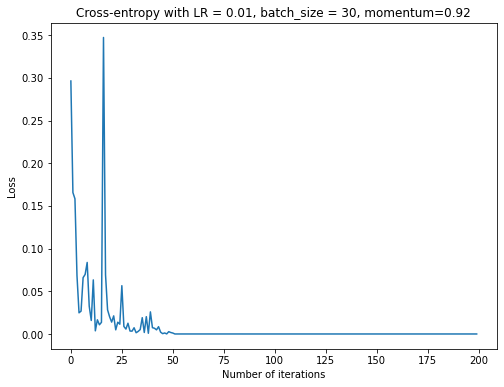

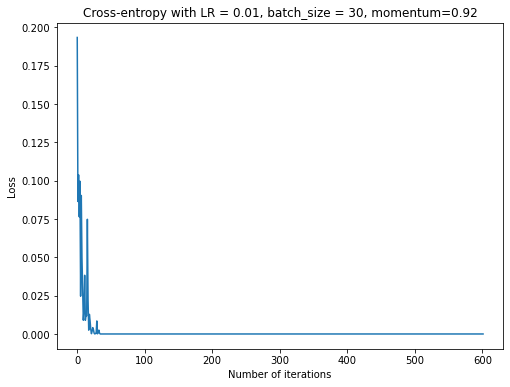

Time:  4.26569864899966
Accuracy of the 5-fold: [0.9083333333333333, 0.8638888888888889, 0.9387186629526463, 0.9192200557103064, 0.9164345403899722]
Accuracy_CE of the 5-fold: [0.681497402677613, 0.5323384775929352, 0.8293594241224924, 0.7784614241374516, 0.6338714707998456]


In [ ]:
# for digits dataset
# Try the combination of Hyper-parameters after grid searching
start = timeit.default_timer()

scores = []
scores_CE = []
for train_index, test_index in myKFold(split = 5, size = len(X_digits)): # Run 5 times
    X_train, X_test, Y_train, Y_test = X_digits[train_index], X_digits[test_index], Y_digits[train_index], Y_digits[test_index]
    optimizer = GradientDescent(learning_rate=.01, batch_size=30, beta = 0.92, record_history=True) # max_iters=1e4
    model = MultiClassLogisticRegression()
    model.fit(X_train, Y_train, optimizer)
    #print(model.weights) # Open this line to see the W
    X_test = np.insert(X_test, 0, 1, axis=1)
    Y_result = optimizer.predict(X_test, model.weights)
    
    score_CE = accuracy_CE(Y_result, Y_test)
    scores_CE.append(score_CE)
    score = accuracy(Y_result, Y_test)
    scores.append(score)   

    fig = plt.figure(figsize=(8,6))
    plt.plot(np.arange(len(optimizer.loss_history)), optimizer.loss_history)
    plt.title("Cross-entropy with LR = "+str(optimizer.learning_rate)+", batch_size = "+str(optimizer.batch_size) + ", momentum=" + str(optimizer.beta))
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.show()

stop = timeit.default_timer()
print('Time: ', stop - start) 
print("Accuracy of the 5-fold: " + str(scores))
print("Accuracy_CE of the 5-fold: " + str(scores_CE))

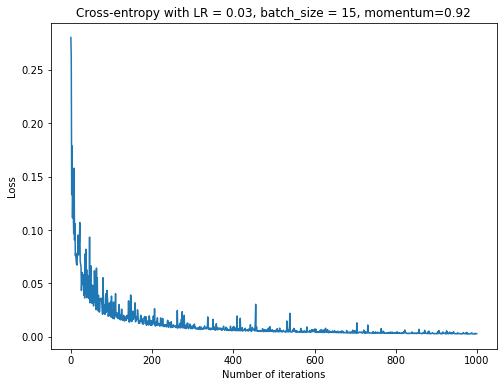

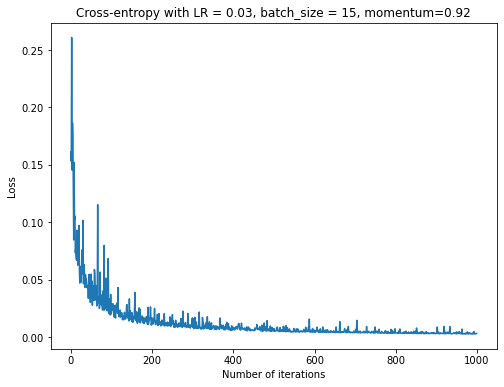

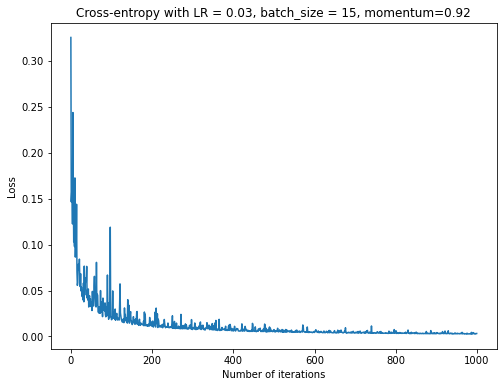

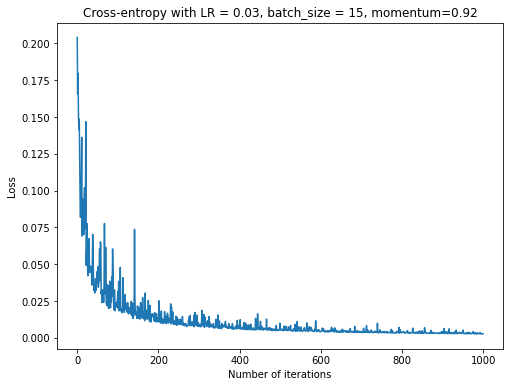

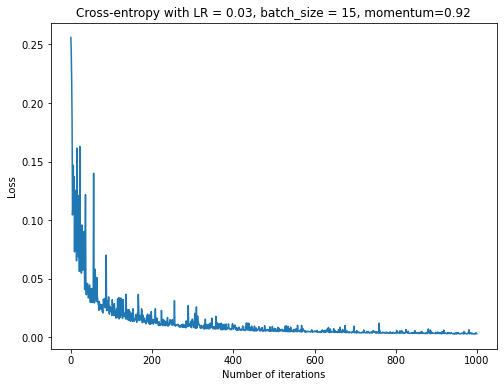

Time:  12.447970862000147
Accuracy of the 5-fold: [0.9768518518518519, 0.9814814814814815, 0.9814814814814815, 0.9768518518518519, 0.9907407407407407]
Accuracy_CE of the 5-fold: [0.6338714707998456, 0.6338714707998456, 0.6338714707998456, 0.6338714707998456, 0.6338714707998456]


In [ ]:
#for mice dataset
# Try the combination of Hyper-parameters after grid searching
start = timeit.default_timer()

scores_CE_mice = []
scores_mice = []
for train_index, test_index in myKFold(split = 5, size = len(X_mice)): # Run 5 times
    X_train_mice, X_test_mice, Y_train_mice, Y_test_mice = X_mice[train_index], X_mice[test_index], Y_mice[train_index], Y_mice[test_index]

    optimizer = GradientDescent(learning_rate=.03, batch_size=15, beta = 0.92, record_history=True) 
    model = MultiClassLogisticRegression()
    model.fit(X_train_mice, Y_train_mice, optimizer)
    #print(model.weights) # Open this line to see the W
    X_test_mice = np.insert(X_test_mice, 0, 1, axis=1)
    Y_result_mice = optimizer.predict(X_test_mice, model.weights)
    
    score_CE_mice = accuracy_CE(Y_result, Y_test)
    scores_CE_mice.append(score_CE_mice)
    score_mice = accuracy(Y_result_mice, Y_test_mice)
    scores_mice.append(score_mice)

    fig = plt.figure(figsize=(8,6))
    plt.plot(np.arange(len(optimizer.loss_history)), optimizer.loss_history)
    plt.title("Cross-entropy with LR = "+str(optimizer.learning_rate)+", batch_size = "+str(optimizer.batch_size) + ", momentum=" + str(optimizer.beta))
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.show()

stop = timeit.default_timer()
print('Time: ', stop - start) 
print("Accuracy of the 5-fold: " + str(scores_mice))
#print("Accuracy_CE of the 5-fold: " + str(scores_CE_mice))

/Users/yuelinliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
<ipython-input-4-fe159aa4a71d>:71: RuntimeWarning: divide by zero encountered in log
  return -1 * np.mean(y * np.log(probs))
<ipython-input-4-fe159aa4a71d>:71: RuntimeWarning: invalid value encountered in multiply
  return -1 * np.mean(y * np.log(probs))


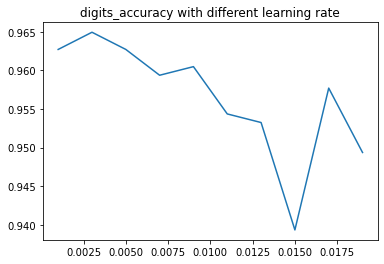

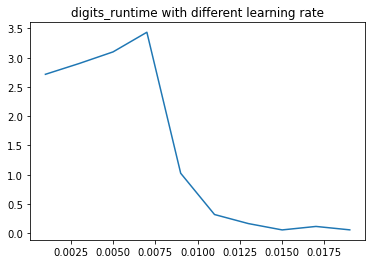

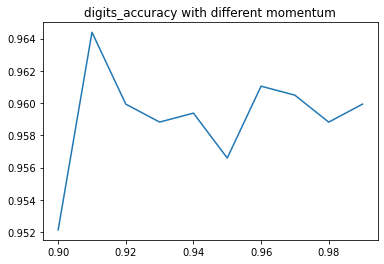

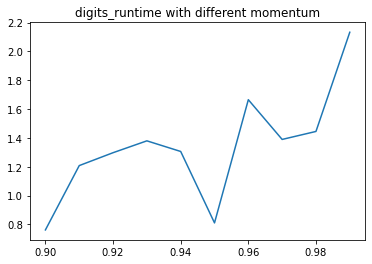

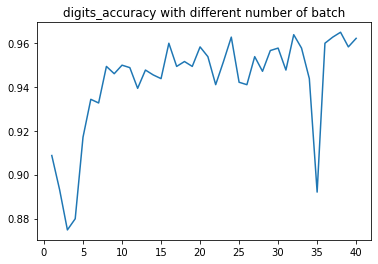

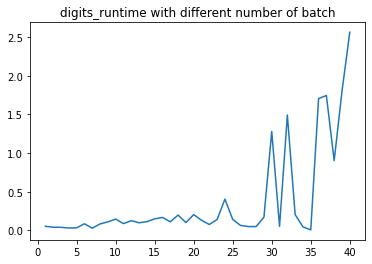

In [ ]:
# For digits
#hyperparameter learning rate 

learning_rate_test = [0.001 + 0.002*i for i in range(10)]
performance = []
runtime_= []

for lrate in learning_rate_test: 
  cv_accuracy, runtime = cvD(X_digits, Y_digits, lrate, num_batch = 30, m=0.92)
  performance.append(cv_accuracy)
  runtime_.append(runtime)

plt.plot(learning_rate_test, performance)
plt.title('digits_accuracy with different learning rate')
plt.show()

plt.plot(learning_rate_test, runtime_)
plt.title('digits_runtime with different learning rate')
plt.show()


#hyperparameter momentum

Ms = [0.9 + 0.01 * i for i in range(10)]
performance = []
runtime_= []

for b in Ms: 
  cv_accuracy, runtime = cvD(X_digits, Y_digits, lrate=0.01, num_batch=30, m=b)
  performance.append(cv_accuracy)
  runtime_.append(runtime)
    
plt.plot(Ms, performance)
plt.title('digits_accuracy with different momentum')
plt.show()

plt.plot(Ms, runtime_)
plt.title('digits_runtime with different momentum')
plt.show()


#hyperparameter number of batch

number_of_batches = [1 + i for i in range(40)]
performance = []
runtime_= []

for nb in number_of_batches: 
  cv_accuracy, runtime = cvD(X_digits, Y_digits, lrate = 0.01, num_batch = nb, m=0.92)
  performance.append(cv_accuracy)
  runtime_.append(runtime)

plt.plot(number_of_batches, performance)
plt.title('digits_accuracy with different number of batch')
plt.show()

plt.plot(number_of_batches, runtime_)
plt.title('digits_runtime with different number of batch')
plt.show()

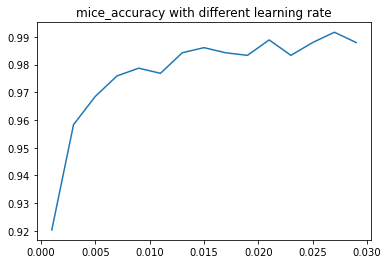

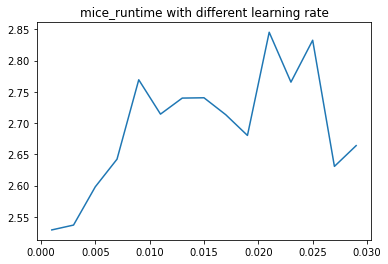

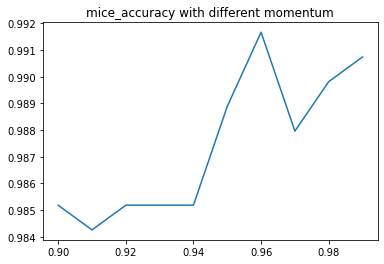

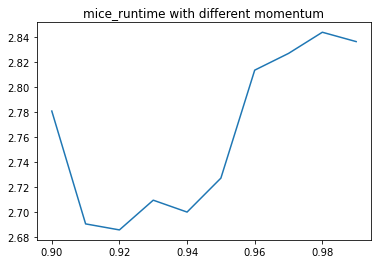

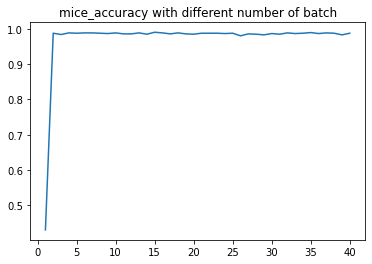

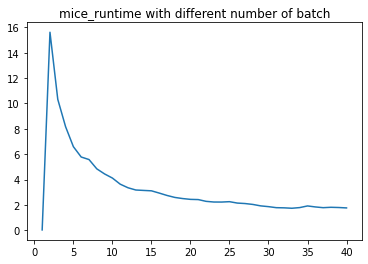

In [ ]:
# For mice set:
#hyperparameter learning rate

learning_rate_test = [0.001 + 0.002*i for i in range(15)]
performance = []
runtime_= []

for lrate in learning_rate_test: 
  cv_accuracy, runtime = cvM(X_mice, Y_mice, lrate, num_batch = 15, m=0.92)
  performance.append(cv_accuracy)
  runtime_.append(runtime)

plt.plot(learning_rate_test, performance)
plt.title('mice_accuracy with different learning rate')
plt.show()

plt.plot(learning_rate_test, runtime_)
plt.title('mice_runtime with different learning rate')
plt.show()


#hyperparameter momentum

Ms = [0.9 + 0.01 * i for i in range(10)]
performance = []
runtime_= []

for b in Ms: 
  cv_accuracy, runtime = cvM(X_mice, Y_mice, lrate=0.03, num_batch=15, m=b)
  performance.append(cv_accuracy)
  runtime_.append(runtime)
    
plt.plot(Ms, performance)
plt.title('mice_accuracy with different momentum')
plt.show()

plt.plot(Ms, runtime_)
plt.title('mice_runtime with different momentum')
plt.show()


#hyperparameter number of batch

number_of_batches = [1 + i for i in range(40)]
performance = []
runtime_= []

for nb in number_of_batches: 
  cv_accuracy, runtime = cvM(X_mice, Y_mice, lrate = 0.03, num_batch = nb, m=0.92)
  performance.append(cv_accuracy)
  runtime_.append(runtime)

plt.plot(number_of_batches, performance)
plt.title('mice_accuracy with different number of batch')
plt.show()

plt.plot(number_of_batches, runtime_)
plt.title('mice_runtime with different number of batch')
plt.show()

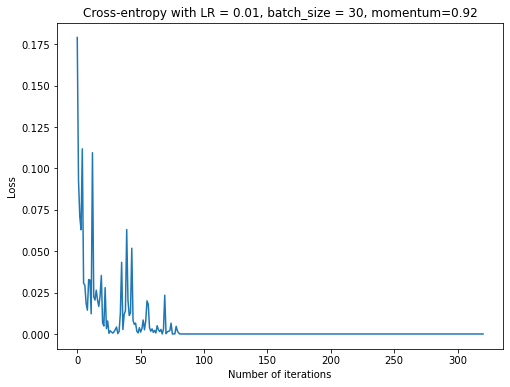

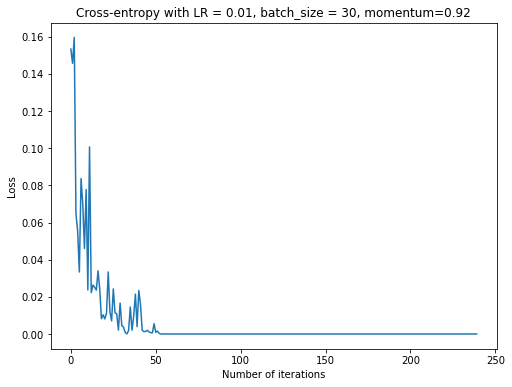

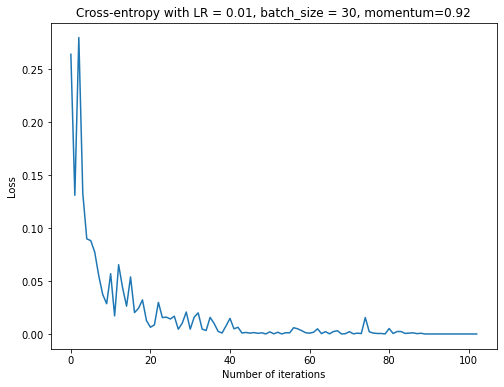

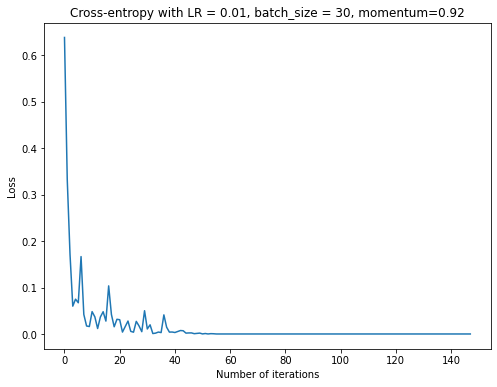

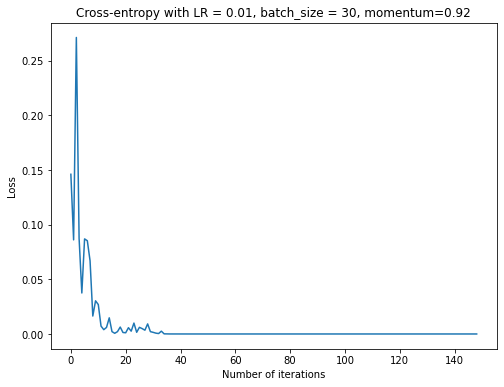

Time:  3.1443491119998725
Accuracy of the 5-fold: [0.925, 0.8638888888888889, 0.9387186629526463, 0.9303621169916435, 0.9080779944289693]
Accuracy_CE of the 5-fold: [0.7595525610593062, 0.5350066627163814, 0.8378543932731324, 0.7702155226979233, 0.6522742787676552]


In [ ]:
# for digits dataset
# Try the final combination of Hyper-parameters
start = timeit.default_timer()

scores = []
scores_CE = []
for train_index, test_index in myKFold(split = 5, size = len(X_digits)): # Run 5 times
    X_train, X_test, Y_train, Y_test = X_digits[train_index], X_digits[test_index], Y_digits[train_index], Y_digits[test_index]
    optimizer = GradientDescent(learning_rate=.01, batch_size=30, beta = 0.92, record_history=True) # max_iters=1e4
    model = MultiClassLogisticRegression()
    model.fit(X_train, Y_train, optimizer)
    #print(model.weights) # Open this line to see the W
    X_test = np.insert(X_test, 0, 1, axis=1)
    Y_result = optimizer.predict(X_test, model.weights)
    
    score_CE = accuracy_CE(Y_result, Y_test)
    scores_CE.append(score_CE)
    score = accuracy(Y_result, Y_test)
    scores.append(score)   

    fig = plt.figure(figsize=(8,6))
    plt.plot(np.arange(len(optimizer.loss_history)), optimizer.loss_history)
    plt.title("Cross-entropy with LR = "+str(optimizer.learning_rate)+", batch_size = "+str(optimizer.batch_size) + ", momentum=" + str(optimizer.beta))
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.show()

stop = timeit.default_timer()
print('Time: ', stop - start) 
print("Accuracy of the 5-fold: " + str(scores))
print("Accuracy_CE of the 5-fold: " + str(scores_CE))

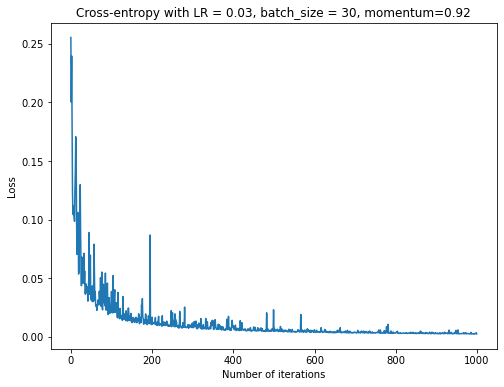

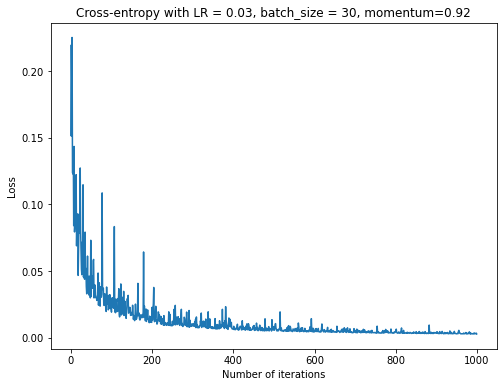

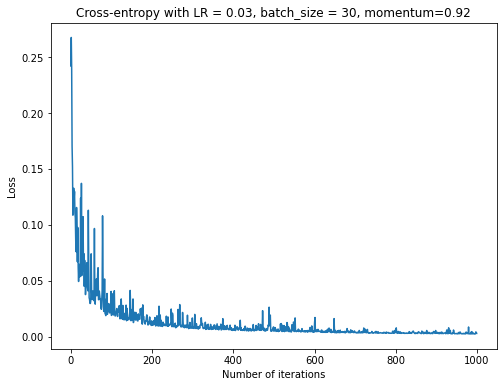

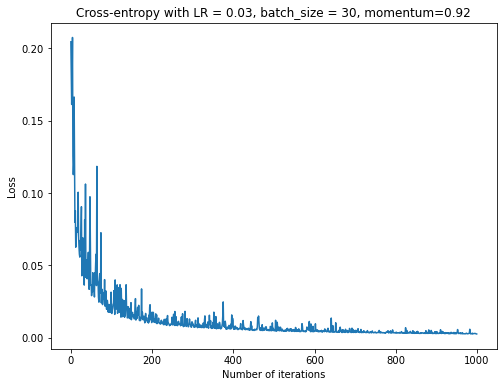

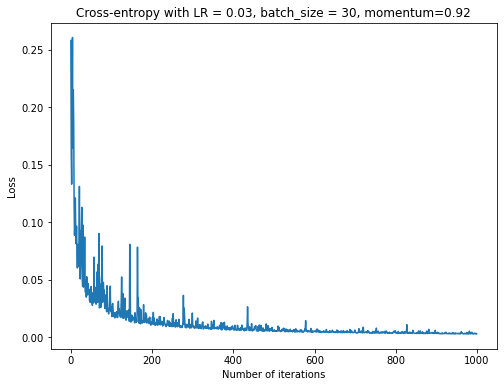

Time:  8.553489879999688
Accuracy of the 5-fold: [0.9768518518518519, 0.9814814814814815, 0.9861111111111112, 0.9814814814814815, 0.9907407407407407]
Accuracy_CE of the 5-fold: [0.6522742787676552, 0.6522742787676552, 0.6522742787676552, 0.6522742787676552, 0.6522742787676552]


In [ ]:
#for mice dataset
# Try the combination of Hyper-parameters after grid searching
start = timeit.default_timer()

scores_CE_mice = []
scores_mice = []
for train_index, test_index in myKFold(split = 5, size = len(X_mice)): # Run 5 times
    X_train_mice, X_test_mice, Y_train_mice, Y_test_mice = X_mice[train_index], X_mice[test_index], Y_mice[train_index], Y_mice[test_index]

    optimizer = GradientDescent(learning_rate=.03, batch_size=30, beta = 0.92, record_history=True) 
    model = MultiClassLogisticRegression()
    model.fit(X_train_mice, Y_train_mice, optimizer)
    #print(model.weights) # Open this line to see the W
    X_test_mice = np.insert(X_test_mice, 0, 1, axis=1)
    Y_result_mice = optimizer.predict(X_test_mice, model.weights)
    
    score_CE_mice = accuracy_CE(Y_result, Y_test)
    scores_CE_mice.append(score_CE_mice)
    score_mice = accuracy(Y_result_mice, Y_test_mice)
    scores_mice.append(score_mice)

    fig = plt.figure(figsize=(8,6))
    plt.plot(np.arange(len(optimizer.loss_history)), optimizer.loss_history)
    plt.title("Cross-entropy with LR = "+str(optimizer.learning_rate)+", batch_size = "+str(optimizer.batch_size) + ", momentum=" + str(optimizer.beta))
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.show()

stop = timeit.default_timer()
print('Time: ', stop - start) 
print("Accuracy of the 5-fold: " + str(scores_mice))
#print("Accuracy_CE of the 5-fold: " + str(scores_CE_mice))

/Users/yuelinliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


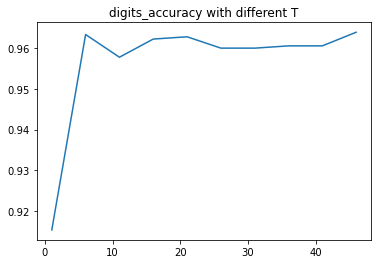

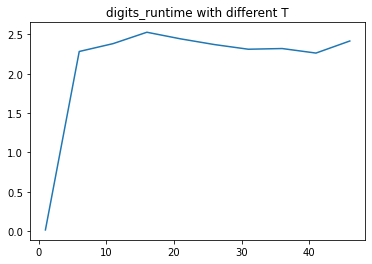

In [ ]:
# Digits set: add hyperparameter T 

Ts = [1 + 5 * i for i in range(10)]
performance = []
runtime_= []

for T in Ts: # Run 5 times
  cv_accuracy, runtime = cvD(X_digits, Y_digits, lrate=0.01, num_batch=30, t=T, m=0.92)
  performance.append(cv_accuracy)
  runtime_.append(runtime)

plt.plot(Ts, performance)
plt.title('digits_accuracy with different T')
plt.show()

plt.plot(Ts, runtime_)
plt.title('digits_runtime with different T')
plt.show()


/Users/yuelinliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


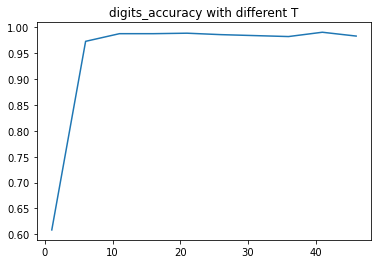

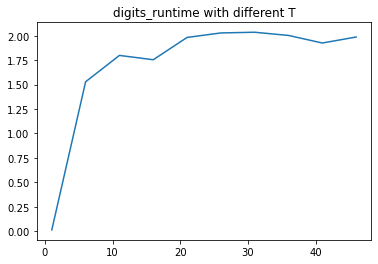

In [ ]:
# Mice set: add hyperparameter T  

Ts = [1 + 5 * i for i in range(10)]
performance = []
runtime_= []

for T in Ts: # Run 5 times
  cv_accuracy, runtime = cvM(X_mice, Y_mice, lrate=0.03, num_batch=30, t=T, m=0.92)
  performance.append(cv_accuracy)
  runtime_.append(runtime)

plt.plot(Ts, performance)
plt.title('mice_accuracy with different T')
plt.show()

plt.plot(Ts, runtime_)
plt.title('mice_runtime with different T')
plt.show()

Since CV are the same for both datasets, all we need to do is passing X_mice and Y_mice as the input instead of X_digits and Y_digits.

/Users/yuelinliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
<ipython-input-32-b2af7e5c637a>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(X_train, Y_train)
<ipython-input-32-b2af7e5c637a>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(X_train, Y_train)
<ipython-input-32-b2af7e5c637a>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(X_train, Y_train)
<ipython-input-32-b2af7e5c637a>:23:

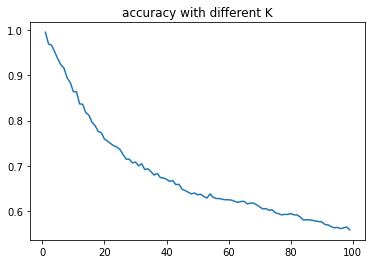

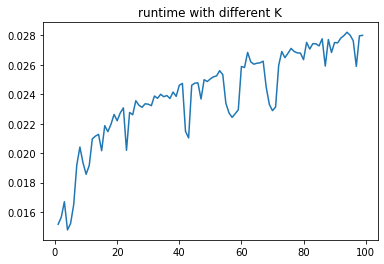

mice hyparameters with the best accuracy: [K]: [1], best_accuracy: 0.9953703703703705


In [ ]:
# compare with KNN on Mice
from sklearn.neighbors import KNeighborsClassifier

def accuracyKNN(y_pre,y):
  count = 0
  y_pre.ravel()
  y.ravel()
  for i in range(len(y)):
    if y_pre[i] == y[i]:
      count += 1
  return count / len(y)

def cvKNN(X,Y,K):    
  cv = KFold(5, True, 1)
  runtime = 0
  vc = 0
  i = 0
  for train_index, test_index in cv.split(X): 
    X_train, X_test, Y_train, Y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
    #optimizer = GradientDescent(learning_rate=lrate, batch_size=num_batch, record_history=True, T = t, beta = m)
    model = KNeighborsClassifier(n_neighbors=K)
    starttime = time.time()
    model.fit(X_train, Y_train)
    #X_test = np.insert(X_test, 0, 1, axis=1)
    Y_result = model.predict(X_test)
    #score = accuracy(Y_result, Y_test)
    score = accuracyKNN(Y_result, Y_test)
    endtime = time.time()
    timecost = endtime - starttime
    i += 1
    # print(f'Training time for current fold {i}: {timecost}')
    runtime += timecost
    vc += score

  valid_accuracy_avg = vc / 5
  runtime_avg = runtime / 5
  # print(f'Average validation accuracy: {valid_accuracy_avg}\n')
  return valid_accuracy_avg, runtime_avg


Ks = range(1,100)
# alphas = [0.008 + 0.0015 * i for i in range (2)]
# number_of_batches = [30 + 5*i for i in range(5)]
# Ts = [50 + 30 * i for i in range(3)]
# Ms = [0.7 + 0.05 * i for i in range(3)]

best_score = 0
best_accuracy = 0
best_hyperparams_accuracy = []
best_hyperparams_score = []

performanceMice = []
runtime_Mice= []
scoresMice = []


for K in Ks:
  # print(f'------------------Training on params: number of neighbors={K}------------- \n')
  # get accuracy for each K 
  vaa, rta = cvKNN(X_mice, Y_mice, K)
  performanceMice.append(vaa)
  runtime_Mice.append(rta)
  scoresMice.append(0.8 * vaa + 0.2 / rta)
  if best_score < 0.8 * vaa + 0.2 / rta:
          best_score = 0.8 * vaa + 0.2 / rta
          best_hyperparams_score = [K]
  if best_accuracy < vaa:
          best_accuracy = vaa
          best_hyperparams_accuracy = [K]
  # for num_batch in number_of_batches:
  #     for t in Ts:
  #       for m in Ms:


plt.plot(Ks, performanceMice)
plt.title('accuracy with different K')
plt.show()

plt.plot(Ks, runtime_Mice)
plt.title('runtime with different K')
plt.show()

print(f'mice hyparameters with the best accuracy: [K]: {best_hyperparams_accuracy}, best_accuracy: {best_accuracy}') 

/Users/yuelinliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
<ipython-input-30-22050e2fa3a2>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(X_train, Y_train)
<ipython-input-30-22050e2fa3a2>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(X_train, Y_train)
<ipython-input-30-22050e2fa3a2>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(X_train, Y_train)
<ipython-input-30-22050e2fa3a2>:23:

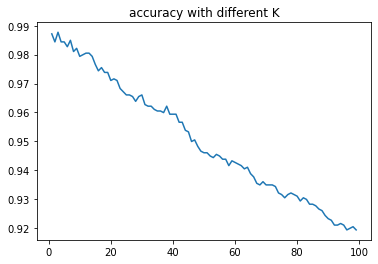

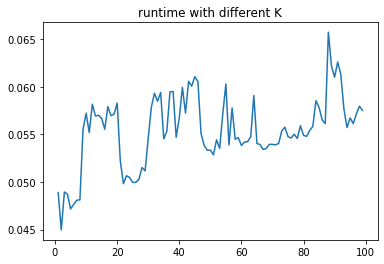

digits hyparameters with the best accuracy: [K]: [3], best_accuracy: 0.9877592076756423


In [ ]:
# Compare KNN with Digits.

best_score = 0
best_accuracy = 0
best_hyperparams_accuracy = []
best_hyperparams_score = []

performanceDigits = []
runtime_Digits= []
scoresDigits = []


for K in Ks:
  #print(f'------------------Training on params: number of neighbors={K}------------- \n')
  # get accuracy for each K 
  vaa, rta = cvKNN(X_digits, Y_digits, K)
  performanceDigits.append(vaa)
  runtime_Digits.append(rta)
  scoresDigits.append(0.8 * vaa + 0.2 / rta)
  if best_score < 0.8 * vaa + 0.2 / rta:
          best_score = 0.8 * vaa + 0.2 / rta
          best_hyperparams_score = [K]
  if best_accuracy < vaa:
          best_accuracy = vaa
          best_hyperparams_accuracy = [K]
  # for num_batch in number_of_batches:
  #     for t in Ts:
  #       for m in Ms:
          

plt.plot(Ks, performanceDigits)
plt.title('accuracy with different K')
plt.show()

plt.plot(Ks, runtime_Digits)
plt.title('runtime with different K')
plt.show()

print(f'digits hyparameters with the best accuracy: [K]: {best_hyperparams_accuracy}, best_accuracy: {best_accuracy}')
